# 🏆️ Competição de Reconhecimento de Faces - IFSP Campinas

## Introdução

Este Jupyter Notebook apresenta nossa abordagem para a competição de Reconhecimento de Faces do Instituto Federal de São Paulo (IFSP) - Campus Campinas, realizada como parte das atividades avaliativas da disciplina Aplicações em Ciência de Dados (D3APL 2023), integrante do curso de Especialização em Ciência de Dados. 

Link para competição: https://www.kaggle.com/competitions/ifsp-d3apl-2023-face-recognition/overview

O principal objetivo deste trabalho é criar um modelo de rede neural capaz de identificar corretamente os rostos de 83 indivíduos a partir de imagens fornecidas. Para alcançar esse objetivo, vamos usar técnicas avançadas de aprendizado de máquina e processamento de imagens.

## 🎯 Objetivo

Nosso objetivo é desenvolver um modelo de aprendizado de máquina, particularmente uma rede neural, que seja capaz de identificar corretamente um rosto em uma imagem. A partir de uma imagem dada, nosso modelo deve determinar corretamente a quem o rosto pertence, dentre um total de 83 possíveis pessoas.

## 🗄️ Dataset

Para treinar e avaliar nosso modelo, vamos utilizar o conjunto de dados PubFig83, que contém imagens coloridas de rostos de 83 artistas, totalizando 13.840 imagens coletadas da internet. Todas as imagens foram previamente redimensionadas para 100x100 pixels e alinhadas de acordo com a posição dos olhos das pessoas retratadas.

O conjunto de dados de treinamento, denominado `train.zip` e `train.csv`, contém um total de 12.180 imagens rotuladas, distribuídas em 83 classes (pessoas).

O desempenho do nosso modelo será avaliado usando um conjunto de testes não rotulado, contendo um total de 1.660 imagens, chamado `test.zip` e `test.csv`.

## Metodologia

1. Pré-processamento dos dados
2. Construção e avaliação de modelos para comparação
3. Treinamento do modelo final

Esta abordagem servirá como um roteiro para a nossa investigação. Agora, vamos começar a explorar nossos dados!


# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, MaxPooling2D,Dropout, Flatten, Activation, BatchNormalization
from keras.applications import ResNet50, VGG16
from keras.layers import GlobalAveragePooling2D
from sklearn.preprocessing import LabelEncoder
from time import perf_counter
import seaborn as sns
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. Pré-processamento dos dados

## 1.1 Usando a GPU

### 💡 Dica Importante: Aceleração de GPU com a NVIDIA

Se você está interessado em utilizar uma placa de vídeo NVIDIA para acelerar seus treinamentos, pode encontrar algumas dificuldades na etapa de instalação. Muitos de nós passamos dias testando vários tutoriais sem muito sucesso. Porém, descobrimos um guia que se provou eficaz. 

O seguinte [Tutorial](https://www.skooterblog.com/2022/12/26/tensorflow-2-10-no-windows-com-suporte-a-gpu-via-condapip-tensorflow-addons-e-spyder/) descreve em detalhes como instalar e configurar o TensorFlow 2.10 no Windows com suporte a GPU, utilizando Conda, Pip, TensorFlow Addons. Este recurso pode ser extremamente útil para quem deseja aproveitar ao máximo o poder de processamento da sua GPU NVIDIA. 

Observe que isso só funciona para o desenvolvimento no jupyter. No Vscode não funcionou.

Não deixe de conferir se essa é uma opção viável para você e seu projeto!


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1.2 Leitura dos dados

Note que durante o desenvolvimento deste trabalho iremos utilizar o conceito de transfer learning, neste sentido é importante configurar as imagens para o formato adequado dos modelos desejados, sendo assim vamos criar funções para que as bases de treino e teste sejam geradas baseados no `input_shape`

In [4]:
def gerar_treino_teste(rows,cols):
    # read the dataframe
    df = pd.read_csv('train.csv')
    
    # iterate over the images
    for i, row in df.iterrows():
        # read the image
        img = cv2.imread(row['image-pathname'])

        # check if the image was correctly opened
        if img is not None:
            # resize the image
            img = cv2.resize(img, (rows, cols))

            # save the image back to disk
            cv2.imwrite(row['image-pathname'], img)
        else:
            print(f"Image not found: {row['image-pathname']}")
    
    # training a Label Encoder from the train set

    #label_encoder = LabelEncoder()
    #label_encoder.fit(df['label'])
    #df["new_label"] = df.apply(lambda x: label_encoder.transform([x["label"]])[0], axis = 1)
    labels = df['label']
    
    dataset_df_full_train, dataset_df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=labels)
    
    #Gerar dados de treinamento
    train_datagen = ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 rotation_range=40,
                                 width_shift_range=0.3,
                                 height_shift_range=0.3)
                                 
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(dataframe=dataset_df_full_train,
                                                        x_col="image-pathname",
                                                        y_col="label",
                                                        target_size=(rows,cols),
                                                        class_mode='categorical')

    test_generator = test_datagen.flow_from_dataframe( dataframe=dataset_df_test,
                                                        x_col="image-pathname",
                                                        y_col="label",
                                                        target_size=(rows,cols),
                                                        class_mode='categorical')
    
    
    
    
    return train_generator, test_generator

In [5]:
train, test = gerar_treino_teste(224,224)

Found 9744 validated image filenames belonging to 83 classes.
Found 2436 validated image filenames belonging to 83 classes.


# 2. Construção e avaliação de modelos para comparação

In [6]:
def graficos(history):
    history_df = pd.DataFrame(history.history)
    history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Score')

In [24]:
def build_cnn2(input_shape=(100, 100, 3), n_classes=83):
    model = Sequential([
        # feature extraction
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPool2D(pool_size=(2,2)),
        
        Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2,2)),
        
        Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2,2)),
        
        Flatten(),
        
        # Fully-Connected Neural Network ==> MLP
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    
    return model

Epoch 1/100
305/305 [==============================] - 14s 44ms/step - loss: 4.6156 - accuracy: 0.0218 - val_loss: 4.3627 - val_accuracy: 0.0279
Epoch 2/100
305/305 [==============================] - 13s 43ms/step - loss: 4.4028 - accuracy: 0.0266 - val_loss: 4.3142 - val_accuracy: 0.0411
Epoch 3/100
305/305 [==============================] - 13s 43ms/step - loss: 4.3600 - accuracy: 0.0331 - val_loss: 4.3032 - val_accuracy: 0.0562
Epoch 4/100
305/305 [==============================] - 13s 43ms/step - loss: 4.3205 - accuracy: 0.0383 - val_loss: 4.2013 - val_accuracy: 0.0562
Epoch 5/100
305/305 [==============================] - 13s 43ms/step - loss: 4.2905 - accuracy: 0.0351 - val_loss: 4.3035 - val_accuracy: 0.0394
Epoch 6/100
305/305 [==============================] - 13s 43ms/step - loss: 4.2556 - accuracy: 0.0422 - val_loss: 4.1118 - val_accuracy: 0.0608
Epoch 7/100
305/305 [==============================] - 13s 43ms/step - loss: 4.2373 - accuracy: 0.0426 - val_loss: 4.0833 - val_ac

Text(0, 0.5, 'Score')

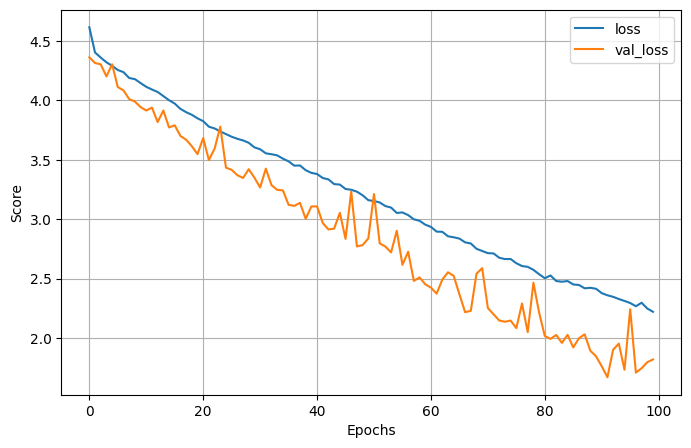

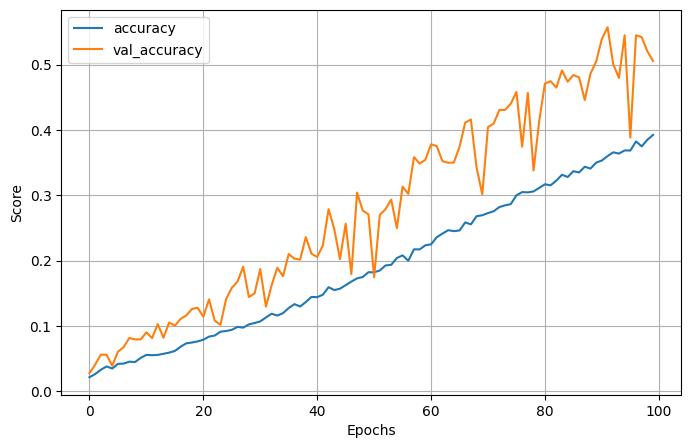

In [25]:
input_shape = (100, 100, 3)
model = build_cnn2(input_shape, 83)
opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(train,
                    validation_data=test, 
                    epochs=100, batch_size=32,  
                    callbacks=[early_stopping_cb])


history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')
history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

## Transfer Learning
Uma alternativa interessante neste caso é procurar por modelos já existentes e avaliar o desenpenho deles neste problema.
Alguns modelos a serem testados:  MobileNetV2,VGGFace e DeepFace

### 2.1 MobileNetV2

In [7]:
from tensorflow.keras.applications import MobileNetV2

In [8]:
trained_model=MobileNetV2(input_shape=(224,224,3),           
                    include_top=False,
                    weights='imagenet')   


trained_model.trainable = True
    
trained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [9]:
last_layer=trained_model.get_layer('out_relu')   
last_layer_output=last_layer.output

In [10]:
x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)
#Add a Dropout layer.
x = tf.keras.layers.Dropout(0.8)(x)                      
# Add a final softmax layer for classification.
x = tf.keras.layers.Dense(83,activation='softmax')(x)

model = tf.keras.Model(trained_model.input,x) 

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
#Summary of the model.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [12]:
#Stop

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint("MobileNetV2.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)


# Fit the model
train_generator, test_generator = gerar_treino_teste(224,224)


history = model.fit(train,
                     validation_data=test,
                     epochs=50,
                     callbacks=[early_stopping_cb,checkpoint],
                     verbose=1)

Found 9744 validated image filenames belonging to 83 classes.
Found 2436 validated image filenames belonging to 83 classes.
Epoch 1/50
305/305 [==============================] - ETA: 0s - loss: 4.6175 - accuracy: 0.0189
Epoch 1: val_loss improved from inf to 4.51890, saving model to MobileNetV2.h5
305/305 [==============================] - 127s 392ms/step - loss: 4.6175 - accuracy: 0.0189 - val_loss: 4.5189 - val_accuracy: 0.0238
Epoch 2/50
305/305 [==============================] - ETA: 0s - loss: 4.3087 - accuracy: 0.0355
Epoch 2: val_loss improved from 4.51890 to 4.30727, saving model to MobileNetV2.h5
305/305 [==============================] - 94s 307ms/step - loss: 4.3087 - accuracy: 0.0355 - val_loss: 4.3073 - val_accuracy: 0.0382
Epoch 3/50
305/305 [==============================] - ETA: 0s - loss: 4.0989 - accuracy: 0.0642
Epoch 3: val_loss did not improve from 4.30727
305/305 [==============================] - 93s 306ms/step - loss: 4.0989 - accuracy: 0.0642 - val_loss: 4.4374

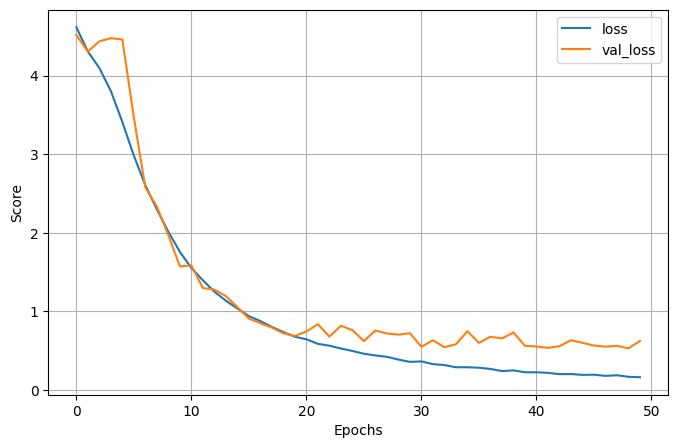

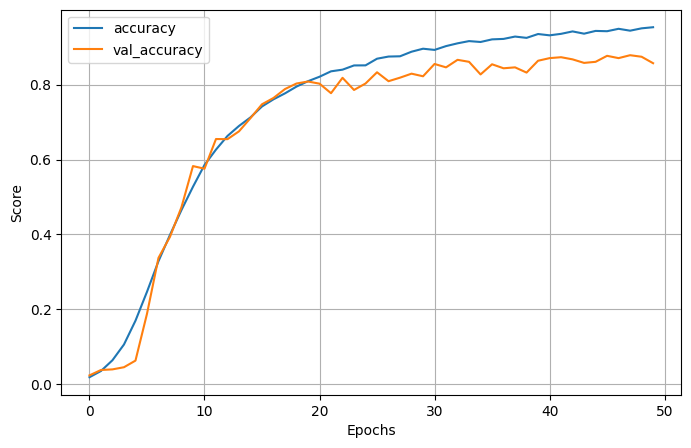

In [13]:
graficos(history)



### 2.2 VGGFace
Neste caso vamos testar VGGFace, em muitos casos ele pode dar erro de importação (`ModuleNotFoundError: No module named 'keras.engine.topology'`) como no meu caso. Para resolver isso devemos substituir o trecho de código:

`from keras.engine.topology import get_source_inputs`

por

`from keras.utils.layer_utils import get_source_inputs`

No arquivo C:\Users\User\.conda\envs\tf\Lib\site-packages\keras_vggface\models.py


In [14]:
from keras_vggface.vggface import VGGFace
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the base pre-trained model
base_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(83, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#Stop

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint("VGG_Face.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)


# Fit the model
train_generator, test_generator = gerar_treino_teste(224,224)

history = model.fit(train_generator,
                     validation_data=test_generator,
                     epochs=50,
                     callbacks=[early_stopping_cb,checkpoint],
                     verbose=1)


Found 9744 validated image filenames belonging to 83 classes.
Found 2436 validated image filenames belonging to 83 classes.
Epoch 1/50
305/305 [==============================] - ETA: 0s - loss: 4.4683 - accuracy: 0.0747
Epoch 1: val_loss improved from inf to 3.21092, saving model to VGG_Face.h5
305/305 [==============================] - 82s 262ms/step - loss: 4.4683 - accuracy: 0.0747 - val_loss: 3.2109 - val_accuracy: 0.5624
Epoch 2/50
305/305 [==============================] - ETA: 0s - loss: 3.2420 - accuracy: 0.2413
Epoch 2: val_loss improved from 3.21092 to 1.03346, saving model to VGG_Face.h5
305/305 [==============================] - 55s 179ms/step - loss: 3.2420 - accuracy: 0.2413 - val_loss: 1.0335 - val_accuracy: 0.8025
Epoch 3/50
305/305 [==============================] - ETA: 0s - loss: 2.4297 - accuracy: 0.3902
Epoch 3: val_loss improved from 1.03346 to 0.52780, saving model to VGG_Face.h5
305/305 [==============================] - 55s 179ms/step - loss: 2.4297 - accuracy:

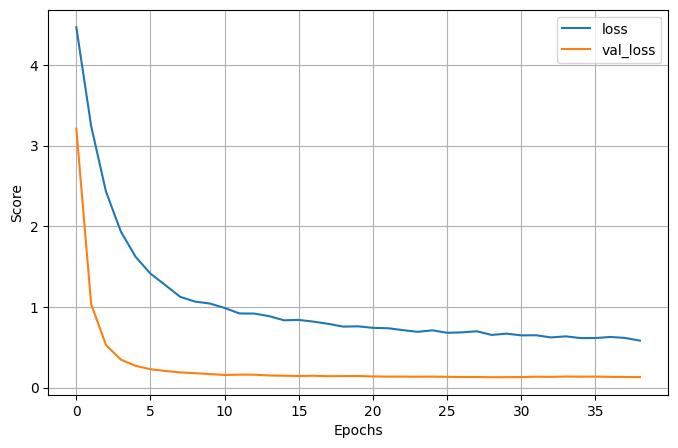

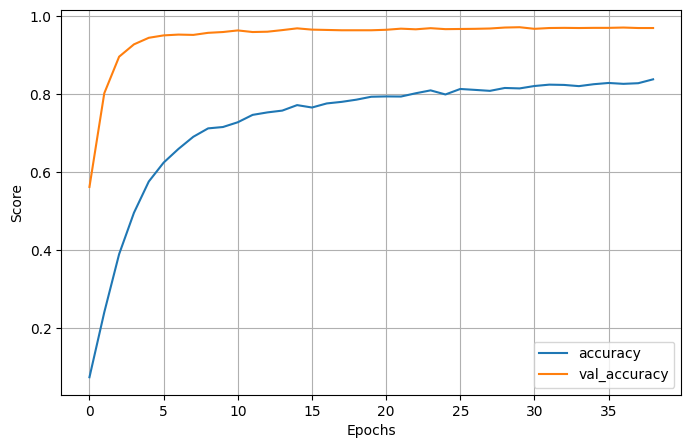

In [15]:
graficos(history)

### 2.3 DeepFace

In [17]:
from deepface import DeepFace
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Create a DeepFace base model
base_model = DeepFace.build_model('VGG-Face')

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for fine-tuning
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(83, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


#Stop

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint("DeepFace.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)


# Fit the model
train_generator, test_generator = gerar_treino_teste(224,224)




Found 9744 validated image filenames belonging to 83 classes.
Found 2436 validated image filenames belonging to 83 classes.


In [18]:

history = model.fit(train_generator,
                     validation_data=test_generator,
                     epochs=50,
                     callbacks=[early_stopping_cb,checkpoint],
                     verbose=1)

Epoch 1/50
305/305 [==============================] - ETA: 0s - loss: 4.1144 - accuracy: 0.1302
Epoch 1: val_loss improved from inf to 3.63272, saving model to DeepFace.h5
305/305 [==============================] - 84s 267ms/step - loss: 4.1144 - accuracy: 0.1302 - val_loss: 3.6327 - val_accuracy: 0.2603
Epoch 2/50
305/305 [==============================] - ETA: 0s - loss: 3.4127 - accuracy: 0.2549
Epoch 2: val_loss improved from 3.63272 to 2.92091, saving model to DeepFace.h5
305/305 [==============================] - 56s 183ms/step - loss: 3.4127 - accuracy: 0.2549 - val_loss: 2.9209 - val_accuracy: 0.4581
Epoch 3/50
305/305 [==============================] - ETA: 0s - loss: 2.8647 - accuracy: 0.3993
Epoch 3: val_loss improved from 2.92091 to 2.34640, saving model to DeepFace.h5
305/305 [==============================] - 56s 183ms/step - loss: 2.8647 - accuracy: 0.3993 - val_loss: 2.3464 - val_accuracy: 0.6244
Epoch 4/50
305/305 [==============================] - ETA: 0s - loss: 2.44

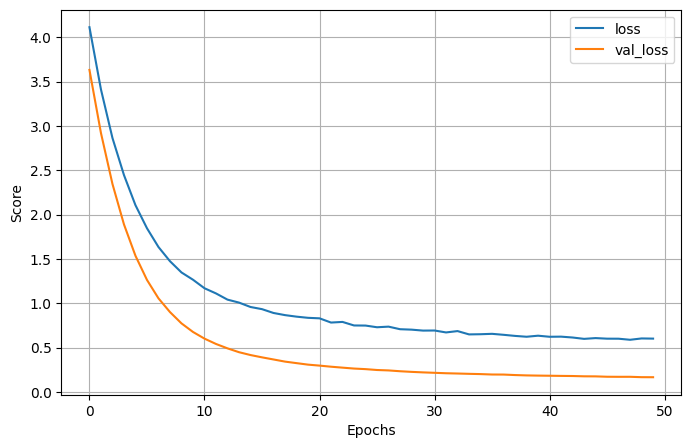

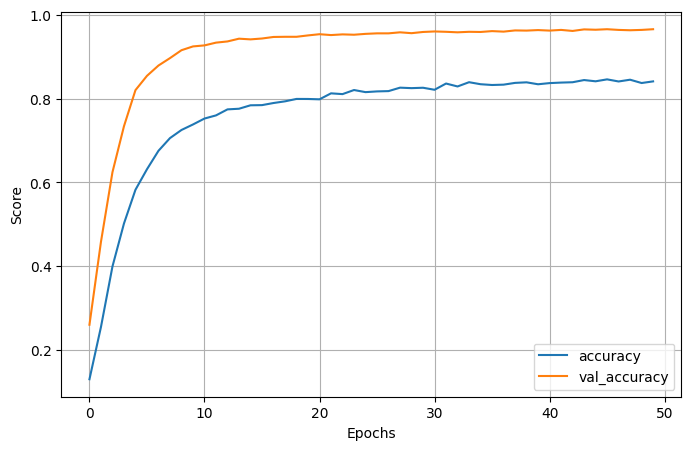

In [19]:
graficos(history)

# 3. Treinamento do modelo final
A partir dos treinamentos anteriores notamos qual a melhor epoca dos treinamentos, sendo assim para cada modelo vamos treinar a mesma quantidade de épocas que a melhor epoca.


In [20]:
def gerar_treino(rows,cols):
    # read the dataframe
    df = pd.read_csv('train.csv')
    
    # iterate over the images
    for i, row in df.iterrows():
        # read the image
        img = cv2.imread(row['image-pathname'])

        # check if the image was correctly opened
        if img is not None:
            # resize the image
            img = cv2.resize(img, (rows, cols))

            # save the image back to disk
            cv2.imwrite(row['image-pathname'], img)
        else:
            print(f"Image not found: {row['image-pathname']}")
    

    #Gerar dados de treinamento
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=(0.8, 1.2),
                                   channel_shift_range=0.2,  # new
                                   fill_mode='nearest',
                                   validation_split=0.2)
                                 

    train_generator = train_datagen.flow_from_dataframe(dataframe=df,
                                                        x_col="image-pathname",
                                                        y_col="label",
                                                        target_size=(rows,cols),
                                                        class_mode='categorical')

    
    
    
    
    return train_generator

In [21]:
train = gerar_treino(224,224)

Found 12180 validated image filenames belonging to 83 classes.


## 3.1 MobileNetV2

In [22]:
from tensorflow.keras.applications import MobileNetV2
trained_model=MobileNetV2(input_shape=(224,224,3),           
                    include_top=False,
                    weights='imagenet')   


trained_model.trainable = True
last_layer=trained_model.get_layer('out_relu')   
last_layer_output=last_layer.output
x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)
#Add a Dropout layer.
x = tf.keras.layers.Dropout(0.8)(x)                      
# Add a final softmax layer for classification.
x = tf.keras.layers.Dense(83,activation='softmax')(x)

model_mobile = tf.keras.Model(trained_model.input,x) 

model_mobile.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint("MobileNetV2_final.h5",
                             monitor="loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)



history = model_mobile.fit(train,
                     epochs=49,
                     callbacks=[early_stopping_cb,checkpoint],
                     verbose=1)

Epoch 1/49
381/381 [==============================] - ETA: 0s - loss: 4.5360 - accuracy: 0.0255
Epoch 1: loss improved from inf to 4.53605, saving model to MobileNetV2_final.h5
381/381 [==============================] - 106s 272ms/step - loss: 4.5360 - accuracy: 0.0255
Epoch 2/49
381/381 [==============================] - ETA: 0s - loss: 4.1561 - accuracy: 0.0597
Epoch 2: loss improved from 4.53605 to 4.15605, saving model to MobileNetV2_final.h5
381/381 [==============================] - 75s 197ms/step - loss: 4.1561 - accuracy: 0.0597
Epoch 3/49
381/381 [==============================] - ETA: 0s - loss: 3.7012 - accuracy: 0.1250
Epoch 3: loss improved from 4.15605 to 3.70122, saving model to MobileNetV2_final.h5
381/381 [==============================] - 75s 197ms/step - loss: 3.7012 - accuracy: 0.1250
Epoch 4/49
381/381 [==============================] - ETA: 0s - loss: 3.1939 - accuracy: 0.2135
Epoch 4: loss improved from 3.70122 to 3.19387, saving model to MobileNetV2_final.h5
381

## 3.2 VGGFace

In [23]:
from keras_vggface.vggface import VGGFace
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the base pre-trained model
base_model = VGGFace(model='vgg16', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(83, activation='softmax')(x)

# This is the model we will train
model_vgggface = Model(inputs=base_model.input, outputs=predictions)

# Compile the model (should be done *after* setting layers to non-trainable)
model_vgggface.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#Stop

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint("VGG_Face_final.h5",
                             monitor="loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)


history = model_vgggface.fit(train,
                     epochs=29,
                     callbacks=[early_stopping_cb,checkpoint],
                     verbose=1)

Epoch 1/29
381/381 [==============================] - ETA: 0s - loss: 3.8822 - accuracy: 0.1576
Epoch 1: loss improved from inf to 3.88215, saving model to VGG_Face_final.h5
381/381 [==============================] - 75s 197ms/step - loss: 3.8822 - accuracy: 0.1576
Epoch 2/29
381/381 [==============================] - ETA: 0s - loss: 2.2944 - accuracy: 0.4328
Epoch 2: loss improved from 3.88215 to 2.29441, saving model to VGG_Face_final.h5
381/381 [==============================] - 74s 195ms/step - loss: 2.2944 - accuracy: 0.4328
Epoch 3/29
381/381 [==============================] - ETA: 0s - loss: 1.5914 - accuracy: 0.5903
Epoch 3: loss improved from 2.29441 to 1.59136, saving model to VGG_Face_final.h5
381/381 [==============================] - 74s 195ms/step - loss: 1.5914 - accuracy: 0.5903
Epoch 4/29
381/381 [==============================] - ETA: 0s - loss: 1.2719 - accuracy: 0.6631
Epoch 4: loss improved from 1.59136 to 1.27195, saving model to VGG_Face_final.h5
381/381 [=======

## 3.3 FaceNet

In [24]:
from deepface import DeepFace
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Create a DeepFace base model
base_model = DeepFace.build_model('VGG-Face')

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for fine-tuning
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(83, activation='softmax')(x)

# This is the model we will train
model_facenet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_facenet.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


#Stop

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint("DeepFace_final.h5",
                             monitor="loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

history = model_facenet.fit(train,
                     epochs=50,
                     callbacks=[early_stopping_cb,checkpoint],
                     verbose=1)

Epoch 1/50
381/381 [==============================] - ETA: 0s - loss: 4.0047 - accuracy: 0.1690
Epoch 1: loss improved from inf to 4.00466, saving model to DeepFace_final.h5
381/381 [==============================] - 75s 196ms/step - loss: 4.0047 - accuracy: 0.1690
Epoch 2/50
381/381 [==============================] - ETA: 0s - loss: 3.1381 - accuracy: 0.3537
Epoch 2: loss improved from 4.00466 to 3.13813, saving model to DeepFace_final.h5
381/381 [==============================] - 74s 194ms/step - loss: 3.1381 - accuracy: 0.3537
Epoch 3/50
381/381 [==============================] - ETA: 0s - loss: 2.4946 - accuracy: 0.5069
Epoch 3: loss improved from 3.13813 to 2.49464, saving model to DeepFace_final.h5
381/381 [==============================] - 74s 194ms/step - loss: 2.4946 - accuracy: 0.5069
Epoch 4/50
381/381 [==============================] - ETA: 0s - loss: 2.0251 - accuracy: 0.6169
Epoch 4: loss improved from 2.49464 to 2.02514, saving model to DeepFace_final.h5
381/381 [=======

## 3.4 Classificação final

In [25]:
classes=train.class_indices
class_names=list(classes.keys()) 

In [26]:
df_test = pd.read_csv('test.csv')

In [27]:
df_test.head()

,image-id,image-pathname
0,1,test/0001.jpg
1,2,test/0002.jpg
2,3,test/0003.jpg
3,4,test/0004.jpg
4,5,test/0005.jpg


In [28]:
def predict(path, modeloo):
      #List of the class names
    img = tf.keras.preprocessing.image.load_img(
        path, target_size=(224, 224)
    )

    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    img_array=img_array/255.

    score = modeloo.predict(img_array)

    return class_names[np.argmax(score)]

In [29]:
df_test["Mobile"] = df_test.apply(lambda row: predict(row["image-pathname"], model_mobile),axis = 1)

1/1 [==============================] - 0s 12ms/step


In [30]:
df_test["VGGFace"] = df_test.apply(lambda row: predict(row["image-pathname"], model_vgggface),axis = 1)

1/1 [==============================] - 0s 11ms/step


In [31]:
df_test["FaceNet"] = df_test.apply(lambda row: predict(row["image-pathname"], model_facenet),axis = 1)

1/1 [==============================] - 0s 11ms/step


In [32]:
df_test

,image-id,image-pathname,Mobile,VGGFace,FaceNet
0,1,test/0001.jpg,Faith Hill,Faith Hill,Faith Hill
1,2,test/0002.jpg,Hugh Laurie,Daniel Craig,Daniel Craig
2,3,test/0003.jpg,Ben Affleck,Steve Carell,Steve Carell
3,4,test/0004.jpg,Shakira,Alec Baldwin,Alec Baldwin
4,5,test/0005.jpg,Sharon Stone,Michael Bloomberg,Michael Bloomberg
...,...,...,...,...,...
1655,1656,test/1656.jpg,Jessica Simpson,Stephen Colbert,Stephen Colbert
1656,1657,test/1657.jpg,Orlando Bloom,Kate Winslet,Kate Winslet
1657,1658,test/1658.jpg,Kate Moss,Mariah Carey,Mariah Carey
1658,1659,test/1659.jpg,Jennifer Aniston,Jennifer Aniston,Jennifer Aniston


In [35]:
def classificacao_final(row):
    if row["VGGFace"] == row["FaceNet"]:
        return row["VGGFace"]
    elif row["VGGFace"] == row["Mobile"]:
        return row["VGGFace"]
    elif row["FaceNet"] == row["Mobile"]:
        return row["FaceNet"]
    else:
        return row["VGGFace"]

In [36]:
df_test["prediction"] = df_test.apply(lambda row: classificacao_final(row),axis = 1)

In [37]:
df_test[df_test["prediction"] != df_test["VGGFace"]]

,image-id,image-pathname,Mobile,VGGFace,FaceNet,prediction
186,187,test/0187.jpg,Victoria Beckham,Charlize Theron,Victoria Beckham,Victoria Beckham
274,275,test/0275.jpg,Brad Pitt,Ben Affleck,Brad Pitt,Brad Pitt


In [43]:
df_test = df_test[["image-id" , "prediction"]]

In [44]:
df_test.to_csv("entrega_2.csv",index = False)

# 4. Conclusões 🎯

Neste trabalho, vivenciei de perto o lema "se tiver tempo, teste". 🕐🔬 Dias foram investidos na configuração da minha máquina para habilitar o uso da GPU, na instalação de recursos um pouco desatualizados no Python, e em manipulações extensas de código para obter resultados satisfatórios para o problema de reconhecimento facial. 🖥️🐍

Fiquei verdadeiramente surpreso com o desempenho da rede mais simples - que atingiu uma precisão de 50%, sendo tão básica. 🥳💻 No entanto, confesso que senti um pouco de decepção com alguns modelos de transfer learning. Meu entusiasmo para testar inúmeras possibilidades resultou em uma ligeira perda de foco com o tempo, mas, de maneira geral, considero o resultado final satisfatório.👍

Minha vontade era de ter experimentado mais classificadores no final das redes de transfer learning. Porém, os treinamentos estavam consumindo um tempo considerável, mesmo com a assistência da GPU. ⏳⚡ Uma situação semelhante ocorreu com os otimizadores. No código apresentado, é possível observar que alguns treinamentos foram interrompidos intencionalmente, dado que não havia ganhos significativos após algumas épocas.🚦🛑

Testei ainda alguns outros modelos que, infelizmente, apresentaram resultados inferiores e me desapontaram. 😞📉

Se fosse começar hoje novamente neste trabalho, sem dúvida, tomaria como ponto de partida as redes VGGFace e Facenet. 🚀🌐 Além disso, faria uma busca mais ampla por modelos que oferecessem performance tão alta quanto esses, para que a estratégia de ensemble learning fosse mais efetiva. 🧠🔍

A ideia do majority voting no final parece ser uma abordagem promissora, mas para isso, é preciso contar com ao menos três modelos com acurácias semelhantes. No presente caso, isso não ocorreu, pois o modelo MobilenetV2 ficou ligeiramente abaixo dos demais. 💭🏁

Em resumo, esta experiência reforçou a importância da experimentação e da paciência na ciência de dados. Estou ansioso para aplicar as lições aprendidas em futuros projetos! 🎉🚀